# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [4]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob

In [5]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    idxs = list(range(lendata))
    np.random.shuffle(idxs)
    split_point = int(percentage*lendata)
    return idxs[:split_point], idxs[split_point:]

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA, 0.8)


# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True,
                 label_map=Multiclass_labels_correspondances):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set
        self._label_map = label_map
        self._train = train

        # Load all the images and their labels
        image_paths = []
        image_labels = []
        images = []
        for filepath in glob.iglob(f"{path_to_images}/**/*.png"):
            fish_class = os.path.split(os.path.split(filepath)[0])[1]
            if fish_class in label_map:
                image_paths.append(filepath)
                image_labels.append(fish_class)
                # Resize immediately to a square
                images.append(Image.open(filepath).resize((img_size, img_size)))
        
        # Build a pandas dataframe with images and their labels
        dataframe = pd.concat(
            [
                pd.Series(image_paths, name="File").astype(str),
                pd.Series(image_labels, name="Fish Class").astype(str),
                pd.Series(images, name="Image"),
                pd.Series(map(lambda l: label_map[l], 
                            image_labels), name="Label").astype(int),
            ],
            axis=1
        )

        # Transformations are applied lazily (when an image is accessed)       
        transform_list = [transforms.ToTensor()]
        if transform_extra:
            transform_list.append(transform_list)
        self.transform = transforms.Compose(transform_list)

        # Extract the images and labels with the specified file indexes
        self.data = {
            "train": dataframe.loc[dataframe.index[idxs_train]],
            "test": dataframe.loc[dataframe.index[idxs_test]],
            "full": dataframe
        }
        
    def __len__(self):
        # Return the number of samples
        k = "train" if self._train else "test"
        return len(self.data[k])
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the image and its label
        k = "train" if self._train else "test"
        item = self.data[k].iloc[idx]
        return self.transform(item["Image"]), item["Label"]

    ###### Some utility functions for step 2 ######

    def label_counts(self, key):
        # Returns a dictionary of label counts
        counts = dict([(fish_class, 0) for fish_class in self._label_map.keys()])
        for i in range(len(self.data[key])):
            item = self.data[key].iloc[i]
            counts[item["Fish Class"]] += 1
        return counts

    def get_label_samples(self, key):
        # Returns a single sample image for each label
        seen = 0
        samples = dict([(fish_class, None) for fish_class in self._label_map.keys()])
        for i in range(len(self.data[key])):
            if seen == len(samples):
                break
            item = self.data[key].iloc[i]
            if samples[item["Fish Class"]] == None:
                seen += 1
                samples[item["Fish Class"]] = item["Image"]
        return samples


## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

Samples per class (training dataset):
{'Black Sea Sprat': 811, 'Gilt-Head Bream': 797, 'Shrimp': 809, 'Striped Red Mullet': 787, 'Trout': 796}


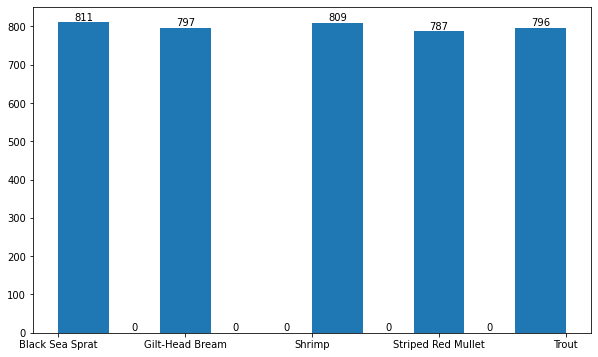

Samples per class (full dataset):
{'Black Sea Sprat': 1000, 'Gilt-Head Bream': 1000, 'Shrimp': 1000, 'Striped Red Mullet': 1000, 'Trout': 1000}

Example images for each class:


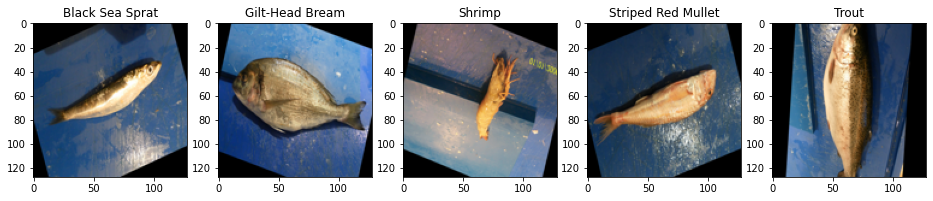

In [6]:
# Training set
img_path = './Fish_Dataset'
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)

# Plot the number of samples per class for the training set
distribution = dataset.label_counts("train")
print(f"Samples per class (training dataset):\n{distribution}")

mylist = [key for key, val in distribution.items() for _ in range(val)]
plt.figure(figsize=(10, 6))
_, _, bars = plt.hist(mylist)
plt.bar_label(bars)
plt.show()

# Print the number of samples per class for the full set
distribution_t = dataset.label_counts("full")
print(f"Samples per class (full dataset):\n{distribution_t}")

# Plot 1 sample from each of the five classes from the training set
print("\nExample images for each class:")
samples = dataset.get_label_samples("train")
fig, axs = plt.subplots(1, len(samples), figsize=(16,9))
for i, (label, image) in enumerate(samples.items()):
    axs[i].title.set_text(label)
    axs[i].imshow(image)
plt.show()

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

**Answers:**

- The raw dataset is perfectly balanced with an equal number of samples per label (1000 each). However, after performing a shuffled train-test set split, there may be a different number of samples per category. In this case, the number of samples per category tend towards the same value (~800) and the differences between each class is very small (the biggest difference is only 24 images). Therefore, there is no large imbalance and it should not affect the performance of the model (ie: it won't be biased towards one class). 

<br>

- Three possible strategies:
  1. Downsample any majority classes (by removing samples) to match a similar number of samples in the other classes.
  2. Upsample any minority classes (by duplicating samples) to match a similar number of samples in the other classes.
  3. Obtain more samples for minority classes (often difficult/expensive but it is the idea solution).

<br>

- The dataset can be considered to be pre-processed to a certain extent. The dataset contains only square images with the fish centered in the image. The images are also rotated at different angles which is better for our model. Further pre-processing techniques could be applied, such as normalising the colour of the images, more accurate centre cropping, etc.

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [7]:
# My network architecture is inspired by LeNet with three convolution layers
# with max pooling, and three fully connected layers at the end.
# I have used the ReLU activation function throughout, as it is known to be
# a robust activation function in deep networks and avoids vanishing gradients.

class Net(nn.Module):
    def __init__(self, output_dims = 5):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            # Convolution-pooling block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolution-pooling block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolution-pooling block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fully connected linear layer (with dropout)
            nn.Flatten(),
            nn.Linear(65536, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.Linear(256, output_dims)
            
            # Note that nn.CrossEntropyLoss() automatically applies
            # a log-softmax activation to its input, so we do not
            # need to explicitly add a Softmax layer here.        
        )

    def forward(self, x):
        # Forward propagation
        return self.layers(x)

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [8]:
# Network
model = Net()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
# I initially tried 10 epochs, but I saw that the loss kept decreasing slightly
# so I decided to increase it to 15. At this point, the loss had plateaued and
# I thought it was not worth increasing the number of epochs further.
epochs = 15

# Training and testing batch size
train_batch_size = 64
test_batch_size = 32

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)

### Step 3.3: Train the model. (15 points)

Complete the training loop.

  7%|▋         | 1/15 [02:35<36:23, 155.98s/it]

--- Iteration 1: training loss = 1.1939 ---


 13%|█▎        | 2/15 [05:08<33:19, 153.79s/it]

--- Iteration 2: training loss = 0.8599 ---


 20%|██        | 3/15 [07:48<31:19, 156.66s/it]

--- Iteration 3: training loss = 0.6470 ---


 27%|██▋       | 4/15 [10:17<28:12, 153.87s/it]

--- Iteration 4: training loss = 0.5251 ---


 33%|███▎      | 5/15 [12:46<25:20, 152.01s/it]

--- Iteration 5: training loss = 0.4386 ---


 40%|████      | 6/15 [15:16<22:41, 151.27s/it]

--- Iteration 6: training loss = 0.3797 ---


 47%|████▋     | 7/15 [17:49<20:13, 151.75s/it]

--- Iteration 7: training loss = 0.3342 ---


 53%|█████▎    | 8/15 [20:16<17:32, 150.40s/it]

--- Iteration 8: training loss = 0.2944 ---


 60%|██████    | 9/15 [22:42<14:54, 149.00s/it]

--- Iteration 9: training loss = 0.2649 ---


 67%|██████▋   | 10/15 [25:12<12:26, 149.34s/it]

--- Iteration 10: training loss = 0.2401 ---


 73%|███████▎  | 11/15 [27:43<09:59, 149.91s/it]

--- Iteration 11: training loss = 0.2221 ---


 80%|████████  | 12/15 [30:22<07:37, 152.64s/it]

--- Iteration 12: training loss = 0.2058 ---


 87%|████████▋ | 13/15 [33:17<05:18, 159.26s/it]

--- Iteration 13: training loss = 0.1908 ---


 93%|█████████▎| 14/15 [35:51<02:37, 157.74s/it]

--- Iteration 14: training loss = 0.1791 ---


100%|██████████| 15/15 [38:29<00:00, 153.99s/it]

--- Iteration 15: training loss = 0.1674 ---


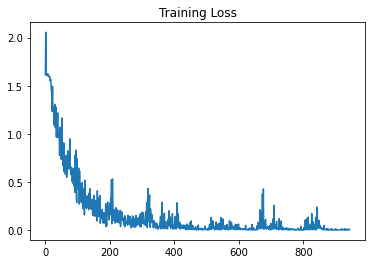

In [9]:
loss_curve = []

for epoch in tqdm(range(epochs)):
    model.train()
    
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labs)
        loss_curve += [loss.item()]

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()
        
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

plt.plot(loss_curve)
plt.title("Training Loss")
plt.show()

### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [11]:
# Deploy the model
predictions = []
actual = []

model.eval()    # Set to evaluation mode

with torch.no_grad():
    for imgs, labs in test_dataloader:
        preds = model(imgs)
        _, pred_labels = torch.max(preds, dim = 1)
        predictions.append(pred_labels.numpy())
        actual.append(labs.numpy())

# Zip the predictions and true values in a list of pairs: [(pred, true)]
pred_actual_pairs = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        pred_actual_pairs.append((predictions[i][j], actual[i][j]))

actuals = [actual for (actual, _) in pred_actual_pairs]
preds = [pred for (_, pred) in pred_actual_pairs]

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Zip the predictions and true values in a list of pairs: [(pred, true)]
pred_actual_pairs = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        pred_actual_pairs.append((predictions[i][j], actual[i][j]))

actuals = [actual for (actual, _) in pred_actual_pairs]
preds = [pred for (_, pred) in pred_actual_pairs]

# Print the accuracy
print(f"Test accuracy (on {len(pred_actual_pairs)} samples): {accuracy_score(actuals, preds):.3f}\n")

# Print the classification metrics for each class
print("Model performance metrics:")
print(classification_report(actuals, preds, target_names=Multiclass_labels_correspondances))

# Print the confusion matrix
inverse_correspondances = dict(
    (v, k)
    for k, v in Multiclass_labels_correspondances.items()
)
print("Confusion matrix:")
conf_matrix = pd.DataFrame(confusion_matrix(actuals, preds))
pd.set_option('display.width', 100)
print(conf_matrix.rename(columns=inverse_correspondances, index=inverse_correspondances))

Test accuracy (on 1000 samples): 0.990

Model performance metrics:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.98      0.99       192
   Gilt-Head Bream       1.00      0.99      0.99       205
            Shrimp       0.99      1.00      0.99       189
Striped Red Mullet       0.97      0.99      0.98       209
             Trout       1.00      0.99      0.99       205

          accuracy                           0.99      1000
         macro avg       0.99      0.99      0.99      1000
      weighted avg       0.99      0.99      0.99      1000

Confusion matrix:
                    Black Sea Sprat  Gilt-Head Bream  Shrimp  Striped Red Mullet  Trout
Black Sea Sprat                 189                0       0                   3      0
Gilt-Head Bream                   0              202       0                   2      1
Shrimp                            0                0     189                   0      0
Striped Red Mullet  

## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [14]:
New_multiclass_labels_correspondances = {
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3
}

LENDATA = 4000 - 1  # Red Mullet/00081.png is corrupted, I have removed it from the dataset
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
train_batch_size = 64
test_batch_size = 32

train_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True, label_map=New_multiclass_labels_correspondances)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
test_dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False, label_map=New_multiclass_labels_correspondances)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [19]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last(model)

# Modify the last layer. This layer is not freezed.
# We need to change the last layer so that the output vector is 4 instead of 5 classes.
model.layers[-1] = nn.Linear(model.layers[-1].in_features, len(New_multiclass_labels_correspondances))
for param in model.layers[-1].parameters():
    param.requires_grad = True

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Number of iterations for training
epochs = 15

### Step 4.3: Train and test your finetuned model. (5 points)

In [20]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    for imgs, labs in train_dataloader:
        # Get a batch of training data and train the model
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labs)
        loss_curve += [loss.item()]

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()
        
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))


# Deploy the model on the test set
predictions = []
actual = []
with torch.no_grad():
    for imgs, labs in test_dataloader:
        preds = model(imgs)
        _, pred_labels = torch.max(preds, dim = 1)
        predictions.append(pred_labels.numpy())
        actual.append(labs.numpy())

pred_actual_pairs = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        pred_actual_pairs.append((predictions[i][j], actual[i][j]))


# Evaluate the performance
actuals = [actual for (actual, _) in pred_actual_pairs]
preds = [pred for (_, pred) in pred_actual_pairs]

# Print the accuracy
print(f"Test accuracy (on {len(pred_actual_pairs)} samples): {accuracy_score(actuals, preds):.3f}")
inverse_correspondances = dict(
    (v, k)
    for k, v in New_multiclass_labels_correspondances.items()
)
print("Confusion matrix:")
conf_matrix = pd.DataFrame(confusion_matrix(actuals, preds))
pd.set_option('display.width', 100)
print(conf_matrix.rename(columns=inverse_correspondances, index=inverse_correspondances))

  7%|▋         | 1/15 [00:39<09:13, 39.55s/it]

--- Iteration 1: training loss = 0.9151 ---


 13%|█▎        | 2/15 [01:23<09:04, 41.89s/it]

--- Iteration 2: training loss = 0.7879 ---


 20%|██        | 3/15 [02:08<08:42, 43.57s/it]

--- Iteration 3: training loss = 0.7497 ---


 27%|██▋       | 4/15 [02:59<08:30, 46.38s/it]

--- Iteration 4: training loss = 0.7247 ---


 33%|███▎      | 5/15 [03:44<07:38, 45.87s/it]

--- Iteration 5: training loss = 0.6931 ---


 40%|████      | 6/15 [04:33<07:01, 46.87s/it]

--- Iteration 6: training loss = 0.6818 ---


 47%|████▋     | 7/15 [05:20<06:17, 47.18s/it]

--- Iteration 7: training loss = 0.6656 ---


 53%|█████▎    | 8/15 [06:07<05:28, 46.93s/it]

--- Iteration 8: training loss = 0.6564 ---


 60%|██████    | 9/15 [06:51<04:35, 45.96s/it]

--- Iteration 9: training loss = 0.6496 ---


 67%|██████▋   | 10/15 [07:36<03:49, 45.82s/it]

--- Iteration 10: training loss = 0.6471 ---


 73%|███████▎  | 11/15 [08:20<03:01, 45.34s/it]

--- Iteration 11: training loss = 0.6294 ---


 80%|████████  | 12/15 [09:06<02:16, 45.35s/it]

--- Iteration 12: training loss = 0.6133 ---


 87%|████████▋ | 13/15 [10:01<01:36, 48.31s/it]

--- Iteration 13: training loss = 0.6187 ---


 93%|█████████▎| 14/15 [10:59<00:51, 51.40s/it]

--- Iteration 14: training loss = 0.6168 ---


100%|██████████| 15/15 [11:49<00:00, 47.31s/it]

--- Iteration 15: training loss = 0.5996 ---


Test accuracy (on 800 samples): 0.741
Confusion matrix:
                 Hourse Mackerel  Red Mullet  Red Sea Bream  Sea Bass
Hourse Mackerel              146           9             13        52
Red Mullet                    21         164              3        17
Red Sea Bream                 29          14            163        18
Sea Bass                      19           3              9       120


### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

**Answer:**

Yes, finetuning seemed to work fairly well considering we have achieved ~74% accuracy and we are only updating the parameters of the final layer.

We froze the first layers so that the model is able to use the same parameters that were trained on the previous dataset of fish. This works because the new species of fish are "fairly similar" in the sense that they are also fish (and not some other animal), and will have a similar shape (and potentially colour). Also, by freezing the first layers, it makes the training process much faster.
